In [111]:
import geopandas as gpd
from ardac_utils import *
import rasterio
import requests
import io
import matplotlib.pyplot as plt
from rasterio.plot import show
from statistics import pvariance


Population variance is a measure of how spread out a group of data points is. Specifically, it quantifies the average squared deviation from the mean. So, if all data points are very close to the mean, the variance will be small; if data points are spread out over a wide range, the variance will be larger.

In [112]:
gs_dem_url = "https://gs.mapventure.org/geoserver/ows?service=WCS&version=2.0.1&request=GetCoverage&CoverageId=astergdem_min_max_avg"

In [113]:
grid = gpd.read_file('/Users/joshpaul/ardac-toolbox/ardac-toolbox/shp/ncar_12km_grid/ncar_12km_degree_days_grid.shp')
places = get_point_gdf_by_category("communities").to_crs(grid.crs)
places = places[places['name'].isin(["Fairbanks", "Anchorage", "Talkeetna", "Valdez", "Bethel", "Utqiaġvik", "Nome"])].reset_index(drop=True)

Anchorage 
 12km NCAR grid cell bounds (EPSG:3338 meters):
 xmin: 204000.0 xmax: 216000.0 ymin: 1248000.0 ymax: 1260000.0 
Population variance of elevation data (ASTER resampled to 1km): 203.44401041666666


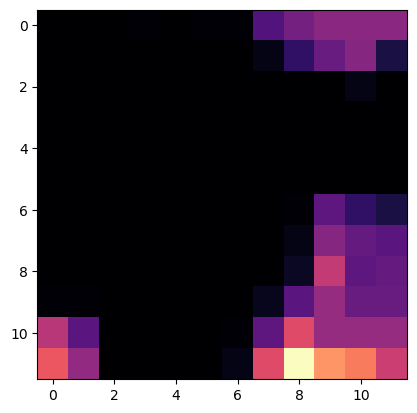

Bethel 
 12km NCAR grid cell bounds (EPSG:3338 meters):
 xmin: -420000.0 xmax: -408000.0 ymin: 1224000.0 ymax: 1236000.0 
Population variance of elevation data (ASTER resampled to 1km): 17.46219135802469


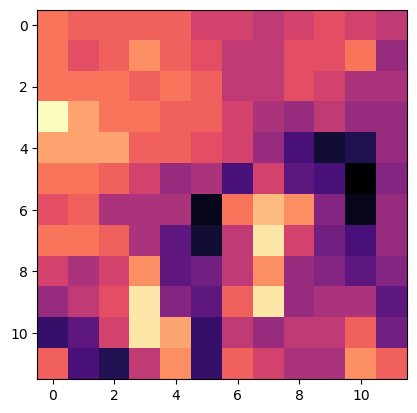

Fairbanks 
 12km NCAR grid cell bounds (EPSG:3338 meters):
 xmin: 288000.0 xmax: 300000.0 ymin: 1656000.0 ymax: 1668000.0 
Population variance of elevation data (ASTER resampled to 1km): 150.09601658950618


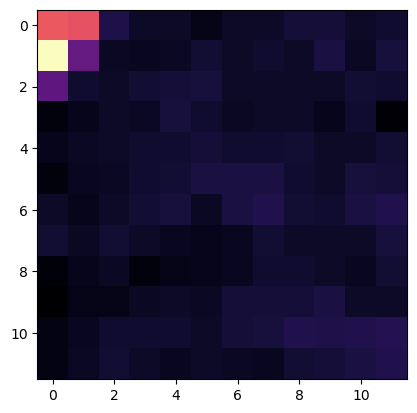

Nome 
 12km NCAR grid cell bounds (EPSG:3338 meters):
 xmin: -552000.0 xmax: -540000.0 ymin: 1656000.0 ymax: 1668000.0 
Population variance of elevation data (ASTER resampled to 1km): 407.86091820987656


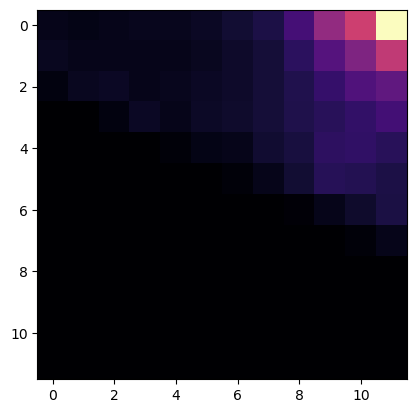

Talkeetna 
 12km NCAR grid cell bounds (EPSG:3338 meters):
 xmin: 192000.0 xmax: 204000.0 ymin: 1368000.0 ymax: 1380000.0 
Population variance of elevation data (ASTER resampled to 1km): 153.45095486111111


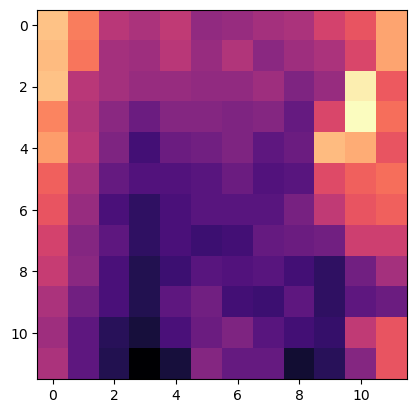

Utqiaġvik 
 12km NCAR grid cell bounds (EPSG:3338 meters):
 xmin: -108000.0 xmax: -96000.0 ymin: 2364000.0 ymax: 2376000.0 
Population variance of elevation data (ASTER resampled to 1km): 34.65581597222222


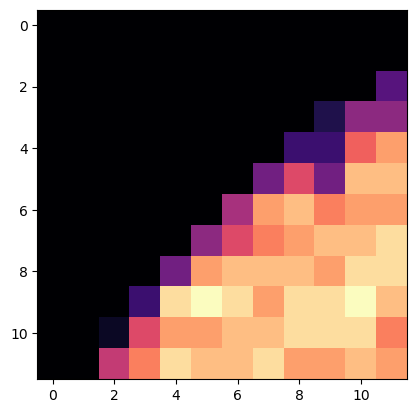

Valdez 
 12km NCAR grid cell bounds (EPSG:3338 meters):
 xmin: 408000.0 xmax: 420000.0 ymin: 1260000.0 ymax: 1272000.0 
Population variance of elevation data (ASTER resampled to 1km): 203791.69888117284


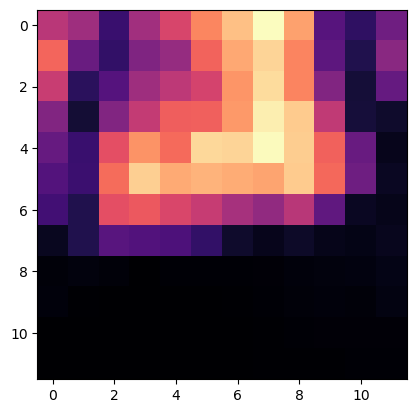

In [114]:
pvar_dict = {}

for place in places['name']:
    bbox = places[places['name']==place].sjoin(grid, how='inner')[['left', 'right', 'top', 'bottom']].astype(str).values.flatten().tolist()
    bbox_str = f"&SUBSET=X({bbox[0]},{bbox[1]})&SUBSET=Y({bbox[3]},{bbox[2]})"
    url = gs_dem_url + bbox_str

    response = requests.get(url)
    if response.status_code == 200:
        ds = rasterio.open(io.BytesIO(response.content))

    avg = ds.read(3) #3rd band is mean elevation in each 1km cell
    pvar = pvariance(avg.flatten().tolist()) #population variance

    pvar_dict[place] = pvar

    print(place, "\n", "12km NCAR grid cell bounds (EPSG:3338 meters):\n", "xmin:", bbox[0], "xmax:", bbox[1], "ymin:", bbox[3], "ymax:", bbox[2], f"\nPopulation variance of elevation data (ASTER resampled to 1km): {pvar}")
    show(avg, cmap='magma')
    

In [115]:
pvar_dict

{'Anchorage': 203.44401041666666,
 'Bethel': 17.46219135802469,
 'Fairbanks': 150.09601658950618,
 'Nome': 407.86091820987656,
 'Talkeetna': 153.45095486111111,
 'Utqiaġvik': 34.65581597222222,
 'Valdez': 203791.69888117284}

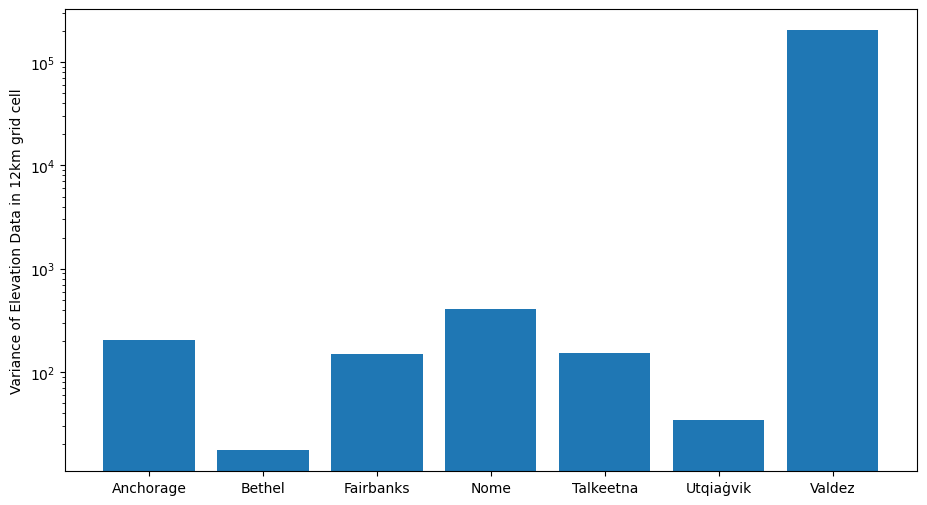

In [122]:
names = list(pvar_dict.keys())
values = list(pvar_dict.values())

fig, ax = plt.subplots(figsize=(11,6))
ax.bar(range(len(pvar_dict)),values,tick_label=names)
plt.yscale("log")
plt.ylabel("Variance of Elevation Data in 12km grid cell")
plt.show()